In [1]:
import numpy as np
def calculate_error_rate(y_pred, y, test_type=""):
    num_errors = np.sum(y_pred != y)
    n = y_pred.shape[0]
    error_rate = (num_errors / n) * 100
    print(f"{test_type} error rate: {error_rate:.2f}%")


In [2]:
import numpy as np
import cvxpy as cp
from scipy.io import loadmat

# Load the dataset
data = loadmat('data/classifier_dataset.mat')

# Extract variables
X_train = data['traindataset']     # Training data (400 x 784)
y_train = data['trainlabels'].flatten()  # Training labels (400,)
N_train, D = X_train.shape

X_test = data['testdataset']       # Test data (1600 x 784)
y_test = data['testlabels'].flatten()    # Test labels (1600,)
N_test = X_test.shape[0]

# Regularization parameter
rho = 0.1
# rho = 0.5

# Define variables for optimization
w0 = cp.Variable()  # Scalar bias term
w = cp.Variable(D)  # Weight vector of size D

# Define the hinge loss function
u = cp.multiply(y_train, w0 + X_train @ w)  # y_n * (w0 + x_n.T @ w)
loss = (1 / N_train) * cp.sum(cp.pos(1 - u))  # Hinge loss
reg = rho * cp.norm(w, 2)**2  # Regularization term
objective = cp.Minimize(loss + reg)

# Solve the optimization problem
problem = cp.Problem(objective)
problem.solve()

# Extract optimal parameters
w0_value = w0.value
w_value = w.value

# Compute predictions and error rate on training data
scores_train = w0_value + X_train @ w_value  # Scores for training data
y_pred_train = np.sign(scores_train)         # Predicted labels for training data

# Handle the case when score is zero (assign label 1 when score is zero)
y_pred_train[scores_train == 0] = 1


calculate_error_rate(y_pred_train, y_train, "Training")

scores_test = w0_value + X_test @ w_value    # Scores for test data
y_pred_test = np.sign(scores_test)           # Predicted labels for test data

# Handle the case when score is zero (assign label 1 when score is zero)
y_pred_test[scores_test == 0] = 1


calculate_error_rate(y_pred_test, y_test, "Test")


(CVXPY) Oct 25 07:34:38 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Oct 25 07:34:38 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


FileNotFoundError: [Errno 2] No such file or directory: 'data/classifier_dataset.mat'

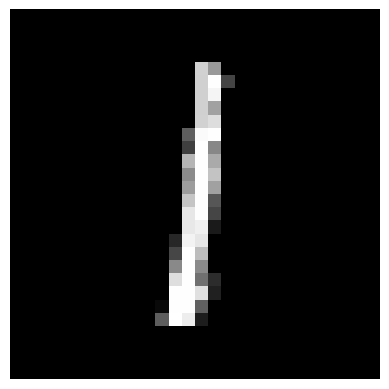

Label: 1


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def show_im(x):
    # Reshape the flattened image back to 28x28
    image = x.reshape(28, 28).T  # Transpose to match the original orientation
    
    # Rescale the image data to [0, 255]
    min_val = np.min(image)
    max_val = np.max(image)
    image_rescaled = (image - min_val) / (max_val - min_val) * 255
    
    # Display the image
    plt.imshow(image_rescaled, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.show()
    
# Example usage
sample_index = 1  # Change this index to view different images
show_im(X_test[sample_index])
print(f'Label: {y_test[sample_index]}')  # -1 for digit 0, 1 for digit 1


In [9]:
## Adversarial Attack Implementation

def compute_perturbation(X, y, w, P):
    """
    Computes the optimal perturbation for a set of inputs.

    Parameters:
    - X: Input data matrix (N x D)
    - y: True labels vector (N,)
    - w: Weight vector of the classifier (D,)
    - P: Perturbation bound (scalar)

    Returns:
    - X_adv: Adversarially perturbed data matrix (N x D)
    """
    # Compute sign(y * w) for each feature
    sign_yw = np.sign(y[:, np.newaxis] * w[np.newaxis, :])  # Shape: (N, D)
    
    # Compute perturbation
    perturbation = P * sign_yw  # Shape: (N, D)
    
    # Apply perturbation: x̃ = x - P * sign(yw)
    X_adv = X - perturbation
    
    # Ensure perturbations are within [-P, P]
    X_adv = np.clip(X_adv, X - P, X + P)
    
    return X_adv

# Define perturbation magnitude P
P = 0.18  # Adjust as needed

# Generate adversarial examples for the test set
X_test_adv = compute_perturbation(X_test, y_test, w_value, P)

# Compute predictions on adversarial test data
scores_test_adv = w0_value + X_test_adv @ w_value
y_pred_test_adv = np.sign(scores_test_adv)
y_pred_test_adv[scores_test_adv == 0] = 1

# Calculate error rate on adversarial test data
calculate_error_rate(y_pred_test_adv, y_test, "Adversarial Test")

Adversarial Test error rate: 43.56%


In [10]:
# Regularization parameter
rho = 0.1

# Perturbation bound
P = 0.18  # You can adjust this value as needed

# Define variables for optimization
w0 = cp.Variable()      # Scalar bias term
w = cp.Variable(D)      # Weight vector of size D

# Compute ||w||_1 once, since it's the same for all samples
w_l1 = cp.norm1(w)


# Define the adjusted hinge loss
# For each sample: h(y_n (w0 + x_n^T w) - P ||w||_1), note that ||w*y||_1 = ||w||_1 because y = {-1, 1}
u = cp.multiply(y_train, w0 + X_train @ w) - P * w_l1
#  y_train * (w0 + X_train @ w) - P * w_l1  # Shape: (N_train,)

# Hinge loss: max(0, 1 - u)
loss = (1 / N_train) * cp.sum(cp.pos(1 - u))

# Regularization term
reg = rho * cp.norm(w, 2)**2  # L2 regularization

# Objective function
objective = cp.Minimize(loss + reg)

# Define and solve the problem
problem = cp.Problem(objective)
problem.solve()

# Extract optimal parameters
w0_value = w0.value
w_value = w.value

# Compute predictions on training data
scores_train = w0_value + X_train @ w_value  # Scores for training data
y_pred_train = np.sign(scores_train)         # Predicted labels for training data

# Handle the case when score is zero (assign label 1 when score is zero)
y_pred_train[scores_train == 0] = 1

# Calculate error rate on training data
calculate_error_rate(y_pred_train, y_train, "Training")

# Compute predictions on test data
scores_test = w0_value + X_test @ w_value    # Scores for test data
y_pred_test = np.sign(scores_test)           # Predicted labels for test data

# Handle the case when score is zero (assign label 1 when score is zero)
y_pred_test[scores_test == 0] = 1

# Calculate error rate on test data
calculate_error_rate(y_pred_test, y_test, "Test")

# Generate adversarial examples for the test set
X_test_adv = compute_perturbation(X_test, y_test, w_value, P)

# Compute predictions on adversarial test data
scores_test_adv = w0_value + X_test_adv @ w_value
y_pred_test_adv = np.sign(scores_test_adv)

# Handle the case when score is zero (assign label 1 when score is zero)
y_pred_test_adv[scores_test_adv == 0] = 1

# Calculate error rate on adversarial test data
calculate_error_rate(y_pred_test_adv, y_test, "Adversarial Test")


Training error rate: 0.75%
Test error rate: 0.44%
Adversarial Test error rate: 2.19%
